In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [147]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, ridge_regression, kalman_filter
from hc_graph import hc_stock

### Financial data loads and cleaning

In [180]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[['HFRXEW']].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[["BNPIFEU","BNPIFUS",
                 "BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 "BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl")[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  "BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  "BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE",]]

In [181]:
prices_all = bnp.join(risk_premia,how="outer").ffill().bfill().join(hfrx,how="inner")

In [183]:
returns_all = prices_all.resample('1D').first().pct_change().dropna()
hrfx_returns = returns_all[["HFRXEW"]]
returns_all = returns_all.drop("HFRXEW", axis=1)

In [207]:
size = 500
freq = 5

df_weight_all = lasso_regression(hrfx_returns, returns_all,sample_length=size, frequency=freq, l=1e-7)
prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("HFRXEW", axis=1)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices_all.loc[replication_all.index][["HFRXEW"]]
df_res["Lasso all"] = replication_all

In [208]:
#regression_pourri = lasso_regression(hrfx_returns, returns_all,sample_length=3686, frequency=1, l=1e-7)
#
#regression_pourri.plot(figsize=(18,6),kind="bar")
#
#weight = regression_pourri.copy()
#weight.loc[prices_all.index[0]] = regression_pourri.iloc[0].values
#make_track(prices_all, weight).plot()
#
#(df_weight_all!=0).sum().plot(figsize=(18,6),kind="bar")

In [209]:
%%time
for nu in [2,4,6,8]:
    df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=nu*0.1 , sigma_return=0.1)\
                    .loc[df_weight_all.index[0]:]

    prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]
    replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
    df_res["Kalman {}".format(nu)] = replication_kalman

CPU times: user 33.6 s, sys: 321 ms, total: 33.9 s
Wall time: 34.2 s


In [210]:
df_res_challet = df_res.loc["2009":]

In [211]:
df_res = df_res/df_res.iloc[0]
df_res_challet = df_res_challet/df_res_challet.iloc[0]

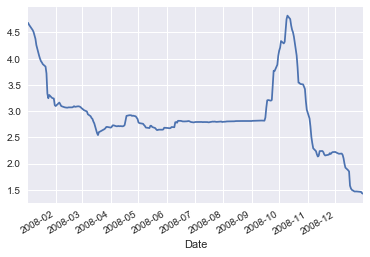

In [216]:
US_rate.loc["2008"].plot()

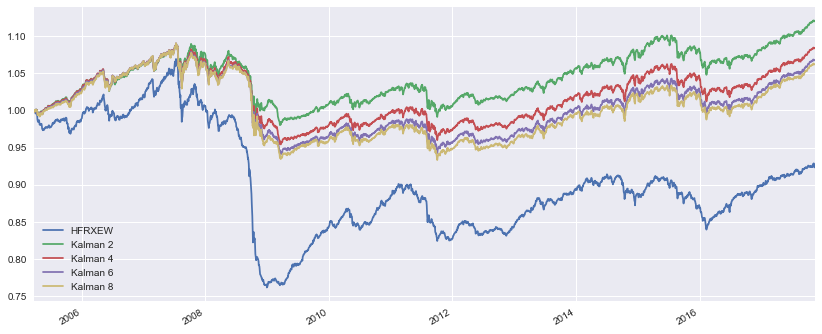

In [212]:
df_res.drop("Lasso all",axis=1).plot(figsize=(14,6))

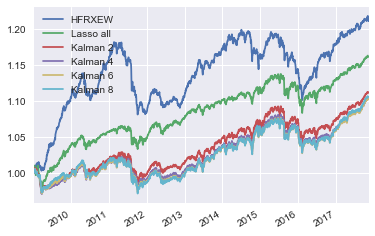

In [215]:
df_res_challet.plot()

In [213]:
df_res.pct_change().corr(method="pearson")

,HFRXEW,Lasso all,Kalman 2,Kalman 4,Kalman 6,Kalman 8
HFRXEW,1.000000,0.025915,0.755042,0.747852,0.735206,0.722679
Lasso all,0.025915,1.000000,0.018725,0.019901,0.021416,0.022987
Kalman 2,0.755042,0.018725,1.000000,0.985693,0.964573,0.945027
Kalman 4,0.747852,0.019901,0.985693,1.000000,0.994488,0.984026
Kalman 6,0.735206,0.021416,0.964573,0.994488,1.000000,0.997105
Kalman 8,0.722679,0.022987,0.945027,0.984026,0.997105,1.000000


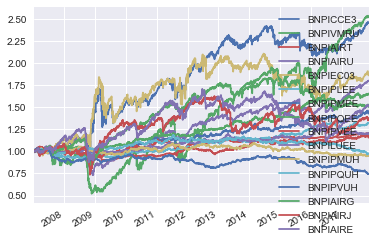

In [171]:
risk_premia.plot()